# plotting functions of figure 5 in the manuscript
This figure shows the results of applying cryoDRGN to the covid spike trimer dataset (DESRES-Trajectory_sarscov2-11021571)



In [7]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.heterogeneity.hetRec import HetRec
from roodmus.heterogeneity.plot_heterogeneous_reconstruction import plot_latent_space_scatter

In [4]:
# data loading for DE-Shaw covid spike partially open set
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
config_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs"
figures_dir = os.path.join(project_dir, "figures")
meta_file = os.path.join(project_dir, "cryoDRGN", "run_data.star")
jobtypes = {
     os.path.join(project_dir, "cryoDRGN", "run_data.star"): "cryoDRGN",
}
latent_file =  os.path.join(project_dir, "cryoDRGN", "train_320", "z.19.pkl")

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True
ignore_missing_files = True
enable_tqdm = True

analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)

df_picked, ndim = HetRec.add_latent_space_coordinates(
    latent_file=latent_file,
    df_picked=df_picked,
)
df_picked, pca = HetRec.compute_PCA(
    df_picked=df_picked,
    ndim=ndim,
)
df_picked.tail()

loading metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/cryoDRGN/run_data.star...
loaded metadata from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/cryoDRGN/run_data.star. determined file type: star


Dictionaries now contain 236079 reconstructed particles
added 236079 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/cryoDRGN/run_data.star


loading truth data: 100%|██████████| 900/900 [08:52<00:00,  1.69it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 236079 particles and 270000 true particles
Added 270000 particles from /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs
For each micrograph, for each metadata file, compute the precision, recall and multiplicity
Speed of computation depends on the number of particles in the micrograph. progressbar is not accurate
Total number of groups to loop over: 900
Number of micgrographs: 900
Number of metadata files: 1
Starting loop over groups


computing precision: 100%|██████████| 900/900 [00:59<00:00, 15.02it/s, precision=1, recall=0.913, multiplicity=0.917]    


time taken to compute precision: 60.51317644119263


,metadata_filename,ugraph_filename,position_x,position_y,euler_phi,euler_theta,euler_psi,ugraph_shape,defocusU,defocusV,...,latent_6,latent_7,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
236074,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000899.mrc,376.0,3850.0,2.338725,0.883299,-2.220564,"(4000, 4000)",24628.760479,24622.810489,...,0.853905,-1.138333,-2.363341,1.830139,-0.479548,2.698073,-1.271468,0.978098,0.253874,0.839972
236075,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000899.mrc,301.0,149.0,2.451085,1.838115,-2.539222,"(4000, 4000)",24591.237560,24585.287570,...,1.672251,2.670263,1.226510,-0.818832,7.751883,-0.578348,-0.941572,0.860968,1.798378,0.832906
236076,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000899.mrc,1308.0,1928.0,-0.475328,1.797999,0.215465,"(4000, 4000)",24669.222376,24663.272386,...,1.769542,1.823054,-3.035149,-2.853707,0.905894,0.371725,0.492588,1.450788,-3.292291,-0.724567
236077,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000899.mrc,1989.0,3653.0,2.810736,0.842498,-2.138002,"(4000, 4000)",24666.868219,24660.918229,...,0.035980,-0.532794,-0.922086,-0.268037,0.849873,2.625923,1.854022,-1.690323,0.257737,0.238584
236078,/home/mjoosten1/projects/roodmus/data/DE-Shaw_...,000899.mrc,1484.0,2611.0,0.736101,1.816983,-2.445191,"(4000, 4000)",24633.333369,24627.383379,...,0.317724,0.633227,-2.741495,-0.433282,-0.439028,2.315344,-1.475152,0.168145,0.315729,-0.621153


## panel A
plotting latent space of epoch 20 of cryoDRGN with the FP particle picks plotted in red

number of FP: 92
number of TP: 235987
saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/z.19.pkl_pca_0_1_FP


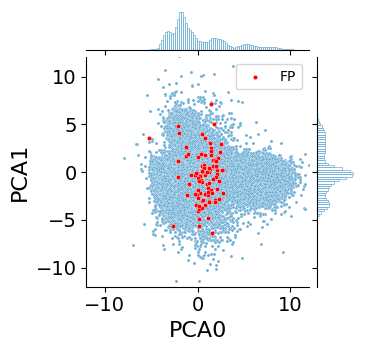

In [9]:
# latent space scatter plot
dim1=0
dim2=1

grid = plot_latent_space_scatter(
    df_picked,
    dim_1=dim1,
    dim_2=dim2,
    # color="#4eb3d3",
    pca=True
)
df_FP = df_picked[df_picked["TP"]==0]
print(f"number of FP: {len(df_FP)}")
print(f"number of TP: {len(df_picked)-len(df_FP)}")
ax = grid.fig.get_axes()[0]
sns.scatterplot(
    data=df_FP,
    x=f"PCA_{dim1}",
    y=f"PCA_{dim2}",
    color="red",
    s=10,
    ax=ax,
    label="FP",
)
grid.set_axis_labels(f"PCA{dim1}", f"PCA{dim2}", fontsize=16)
grid.figure.get_axes()[0].tick_params(labelsize=14)
grid.figure.get_axes()[0].set_xlim((-12, 12))
grid.figure.get_axes()[0].set_ylim((-12, 12))

outfilename = os.path.join(figures_dir, f"{os.path.basename(latent_file)}_pca_{dim1}_{dim2}_FP")
# grid.savefig(outfilename+".pdf", bbox_inches="tight")
# grid.savefig(outfilename+".png", bbox_inches="tight", dpi=600)
print(f"saved figure to: {outfilename}")

## panel B
plot of the latent space with each point coloured by its corresponding frame from the MD trajecory

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/z.19.pkl_latent_space_scatter_colored_by_closest_pdb_index_pca


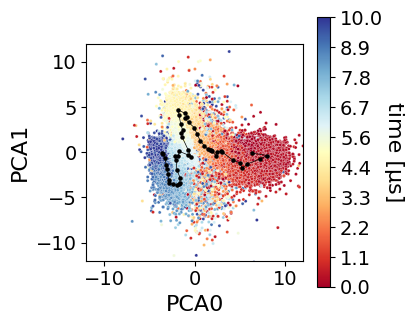

In [10]:
# latent space scatter plot, coloured by ground truth frames
dim1=0
dim2=1
dt = 1.2e-3# time between frames in microseconds

fig, ax = plot_latent_space_scatter(
    df_picked,
    dim_1=dim1,
    dim_2=dim2,
    color_by="closest_pdb_index",
    palette="RdYlBu",
    pca=True,
)
# remove legend and add colorbar for the closest_pdb_index
ax.legend_.remove()
S_m = plt.cm.ScalarMappable(cmap="RdYlBu")
S_m.set_array(df_picked["closest_pdb_index"])
cbar = plt.colorbar(S_m)
cbar.set_label("time [\u03BCs]", rotation=270, labelpad=15, fontsize=16) # time in ps
# change the tick labels on the colorbar to go from 0 to 10 us
cbar.set_ticks(np.linspace(1, df_picked["closest_pdb_index"].max(), 10))
xticklabels = [np.round(r, 1) for r in np.linspace(1, df_picked["closest_pdb_index"].max(), 10)*dt]
cbar.set_ticklabels(xticklabels, fontsize=14)
ax.set_xlabel(f"PCA{dim1}", fontsize=16)
ax.set_ylabel(f"PCA{dim2}", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim((-12, 12))
ax.set_ylim((-12, 12))

# add trajectory to the plot
N_volumes = 50
pdb_indices = np.unique(df_picked["closest_pdb_index"])
d_pdbs = len(pdb_indices) // N_volumes

trajectory = np.zeros((N_volumes, ndim))
trajectory_pca = np.zeros((N_volumes, ndim))
for i in range(N_volumes):
    pdb_group = pdb_indices[i*d_pdbs:(i+1)*d_pdbs]
    mean_latent = df_picked[df_picked["closest_pdb_index"].isin(pdb_group)].agg(
        {f"latent_{i}": "mean" for i in range(ndim)}
    )
    trajectory[i] = mean_latent.values
    mean_pca = df_picked[df_picked["closest_pdb_index"].isin(pdb_group)].agg(
        {f"PCA_{i}": "mean" for i in range(ndim)}
    )
    trajectory_pca[i] = mean_pca.values

ax.scatter(trajectory_pca[:, 0], trajectory_pca[:, 1], s=5, c="black", zorder=10)
ax.plot(trajectory_pca[:, 0], trajectory_pca[:, 1], c="black", zorder=10, linewidth=0.5)
ax.set_aspect("equal")

outfilename = os.path.join(figures_dir, f"{os.path.basename(latent_file)}_latent_space_scatter_colored_by_closest_pdb_index_pca")
# fig.savefig(outfilename+".png", dpi=600, bbox_inches="tight")
# fig.savefig(outfilename+".pdf", bbox_inches="tight")
print(f"saved figure to: {outfilename}")


## panel C
correlation matrix between the MD trajectory and the sampled volumes from the latent space

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/z.19.pkl_correlation_matrix.pdf


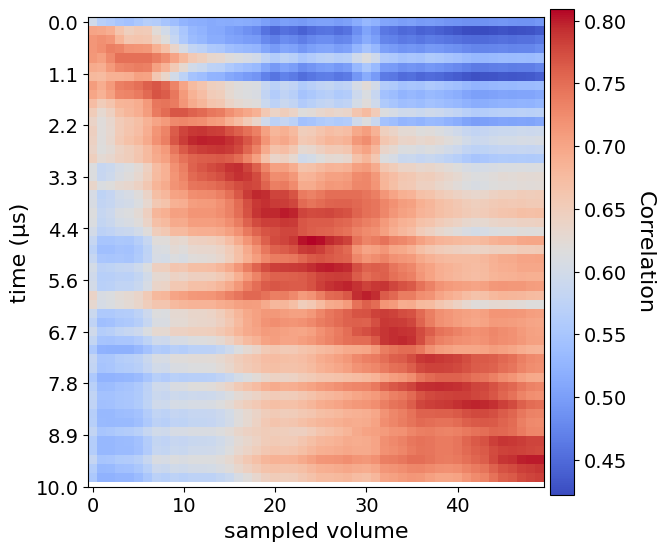

In [11]:
# plot the correlation matrix
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
correlation_matrix_file = os.path.join(project_dir, "cryoDRGN", "analyze_320", "correlation_matrix.npy")
correlation_matrix = np.load(correlation_matrix_file)

frames = correlation_matrix.shape[0]

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(correlation_matrix, cmap="coolwarm")
yticks = np.linspace(0, frames, 10)
yticklabels = np.round(np.linspace(0, 10, 10, dtype=float), 1)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel("time (\u03BCs)", fontsize=16)
ax.set_xlabel("sampled volume", fontsize=16)
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical", pad=0.01, shrink=0.9)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Correlation", fontsize=16, rotation=270, labelpad=20)
ax.tick_params(axis="both", which="major", labelsize=14)

outfilename = os.path.join(figures_dir, f"{os.path.basename(latent_file)}_correlation_matrix.pdf")
# fig.savefig(outfilename, bbox_inches="tight")
print(f"saved figure to: {outfilename}")


In [12]:
# print the best and worst fir for every sampled volume to the MD trahjectory
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021571-all-glueCA/even_sampling_8334"
pdb_files = [r for r in os.listdir(pdb_dir) if r.endswith(".pdb")]
pdb_files.sort()
pdb_files = pdb_files[::int(len(pdb_files)/(frames+1))]
results = {
    "sampled_vol": [],
    "best_fit": [],
    "best_fit_index": [],
    "worst_fit": [],
    "worst_fit_index": [],
}
for i in range(frames):
    results["sampled_vol"].append(i)
    results["best_fit_index"].append(correlation_matrix[i].argmax())
    results["worst_fit_index"].append(correlation_matrix[i].argmin())
    results["best_fit"].append(pdb_files[correlation_matrix[i].argmax()])
    results["worst_fit"].append(pdb_files[correlation_matrix[i].argmin()])

df_results = pd.DataFrame(results)
df_results.head(n=len(df_results))



,sampled_vol,best_fit,best_fit_index,worst_fit,worst_fit_index
0,0,conformation_000000.pdb,0,conformation_006720.pdb,42
1,1,conformation_000000.pdb,0,conformation_006720.pdb,42
2,2,conformation_000160.pdb,1,conformation_006720.pdb,42
3,3,conformation_000320.pdb,2,conformation_006720.pdb,42
4,4,conformation_000960.pdb,6,conformation_006720.pdb,42
5,5,conformation_000800.pdb,5,conformation_006720.pdb,42
6,6,conformation_000800.pdb,5,conformation_006720.pdb,42
7,7,conformation_001120.pdb,7,conformation_006720.pdb,42
8,8,conformation_001120.pdb,7,conformation_006720.pdb,42
9,9,conformation_001280.pdb,8,conformation_006720.pdb,42


## panel D
For this panel I want to write the real-space croscc-correlation between each volume and the best matching frame from the MD trajectory

In [13]:
# print for each sampled volume (column) the correlation with the best matching frame of the trajectory (row), and also the conformation index

pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021571-all-glueCA/even_sampling_8334"
pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
pdb_files.sort()
N = 50
pdb_files = pdb_files[::len(pdb_files)//N]

best_matching_frame = np.argmax(correlation_matrix, axis=0)
best_matching_frame_correlation = np.max(correlation_matrix, axis=0)
best_matching_conformation = [os.path.basename(pdb_files[r]) for r in best_matching_frame]

for i in range(N):
    print(f"{i} {best_matching_frame[i]} {best_matching_frame_correlation[i]} {best_matching_conformation[i]}")

0 3 0.7151523069347612 conformation_000498.pdb
1 3 0.7216029030332209 conformation_000498.pdb
2 3 0.7354171951768349 conformation_000498.pdb
3 4 0.7471215524081343 conformation_000664.pdb
4 4 0.7476609987995663 conformation_000664.pdb
5 7 0.7473169667012631 conformation_001162.pdb
6 7 0.7600684359407512 conformation_001162.pdb
7 8 0.7681504706526968 conformation_001328.pdb
8 8 0.7630203051875004 conformation_001328.pdb
9 10 0.7672424288769066 conformation_001660.pdb
10 13 0.7844633166203994 conformation_002158.pdb
11 13 0.7956191798671678 conformation_002158.pdb
12 13 0.7985797985041961 conformation_002158.pdb
13 13 0.798132085419773 conformation_002158.pdb
14 13 0.7981528654171588 conformation_002158.pdb
15 13 0.7912125439541551 conformation_002158.pdb
16 16 0.7924989695786886 conformation_002656.pdb
17 17 0.7873460701840179 conformation_002822.pdb
18 19 0.7967938427006712 conformation_003154.pdb
19 21 0.796377602291847 conformation_003486.pdb
20 21 0.7960016519978101 conformation_003

In [14]:
# for the first sampled volume, print the correlation with all frames of the trajectory
correlations = correlation_matrix[:, 0]
for i in range(frames):
    print(f"{i} {correlations[i]} {os.path.basename(pdb_files[i])}")

0 0.5984558500905686 conformation_000000.pdb
1 0.7013858886818062 conformation_000166.pdb
2 0.7147258383831732 conformation_000332.pdb
3 0.7151523069347612 conformation_000498.pdb
4 0.7123555561323711 conformation_000664.pdb
5 0.6934615810408447 conformation_000830.pdb
6 0.6782626554541737 conformation_000996.pdb
7 0.7088493185134294 conformation_001162.pdb
8 0.6997179374437553 conformation_001328.pdb
9 0.6726995248976055 conformation_001494.pdb
10 0.6511434090737911 conformation_001660.pdb
11 0.6380899863960273 conformation_001826.pdb
12 0.644496346546095 conformation_001992.pdb
13 0.6423556768568184 conformation_002158.pdb
14 0.6376529993182632 conformation_002324.pdb
15 0.6461463130973395 conformation_002490.pdb
16 0.6136961331475176 conformation_002656.pdb
17 0.6132958891978815 conformation_002822.pdb
18 0.6342945334155178 conformation_002988.pdb
19 0.6064862423576132 conformation_003154.pdb
20 0.607102711322807 conformation_003320.pdb
21 0.6144999052356305 conformation_003486.pdb


## panel E
zoom in of a selected atomic model and map from D. For this A attribute file needs to be made with the Q-scores from ChimeraX

In [15]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
conformation = "007968"
# conformation = "008150"
conformation = "000163"
qscores_file = os.path.join(project_dir, f"chimeraX_qscores_table_conformation_{conformation}.txt")
df_qscores = pd.read_csv(qscores_file, sep="\t" , header=0, skiprows=[1])
df_qscores.tail()


,Chain,Number,Name,Qavg,Qworst,Qbb,Qsc
3310,C,1143,PRO,-0.233,-0.562,-0.168,0.163
3311,C,1144,GLU,-0.304,-0.565,-0.246,0.075
3312,C,1145,LEU,-0.286,-0.536,-0.082,0.135
3313,C,1146,ASP,0.014,-0.262,0.066,0.168
3314,C,1147,SER,-0.227,-0.539,-0.162,0.245


In [16]:
# create an attribute file for ChimeraX
attribute_file = os.path.join(project_dir, f"chimeraX_attributes_conformation_{conformation}.defattr")

recipient = "residues"
matchmode = "1-to-1"
modelnr = "4"

# write comments to the file explaining the attributes
with open(attribute_file, "w") as f:
    f.write(
        "# ChimeraX attributes file\n"
    )
    f.write(
        "# This file contains attributes for the residues of the SARS-CoV-2 spike protein\n"
    )
    f.write(
        "# The attributes are the q-scores of the residues\n"
    )

# write the recipient and match modelines
with open(attribute_file, "a") as f:
    f.write(
        f"recipient: {recipient}\n"
    )
    f.write(
        f"match mode: {matchmode}\n"
    )
    f.write(
        f"attribute: qscore\n"
    )

# add a line for each residue with the qscore as attribute
with open(attribute_file, "a") as f:
    for i, row in df_qscores.iterrows():
        atom_spec = f"#{modelnr}/{row['Chain']}:{row['Number']}"
        attribute = row["Qbb"]
        f.write(
            f"\t{atom_spec}\t{attribute}\n"
        )
        
